In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from tinyai.core import *
from tinyai.learner import *
from tinyai.training import cross_entropy, DataLoaders

set_output()

In [ ]:
import fastcore.all as fc
from fastai.vision.all import show_image, show_images

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [ ]:
from datasets import load_dataset
import torchvision.transforms.functional as TF

dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]

bs = 1024
tds = dsd.with_transform(transformi)
tds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 8000
    })
})

In [ ]:
dls = DataLoaders.from_dd(tds, bs)

In [ ]:
from tinyai.conv import conv
from torch import nn

def get_model():
    return [
        conv(1, 8, ks=5), # 14x14
        conv(8, 16), # 7x7
        conv(16, 32), # 4x4
        conv(32, 64), # 2x2
        conv(64, 10, act=False), # 1x1
        nn.Flatten(),
    ]

In [ ]:
from torcheval.metrics import MulticlassAccuracy
from torch import optim
from tinyai.activations import ActivationStats

metrics = MetricsCB(MulticlassAccuracy())
astats = ActivationStats()

cbs = [metrics, astats]



In [ ]:
def fit(model, epochs=1):
    learn = TrainLearner(model, dls, loss_func=cross_entropy, lr=0.6, cbs=cbs, opt_func=optim.SGD)
    learn.fit(epochs)
    return learn

Epoch,Train,Loss,MulticlassAccuracy
0,eval,2.2974,0.0983


/Users/tom/fun/tinyai/tinyai/training.py:26: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1694493834224/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  target = F.one_hot(target).to(torch.int32).float()


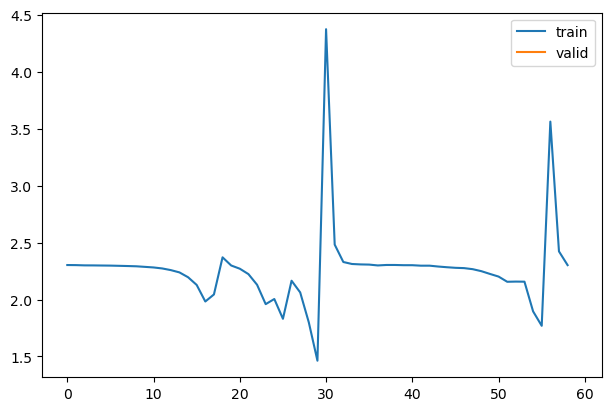

In [ ]:
set_seed(1)
l = fit(nn.Sequential(*get_model()))

## Pytorch Hooks

In [ ]:
set_seed(1)
model = nn.Sequential(*get_model())

In [ ]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

In [ ]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

Epoch,Train,Loss,MulticlassAccuracy
0,eval,2.2974,0.0983


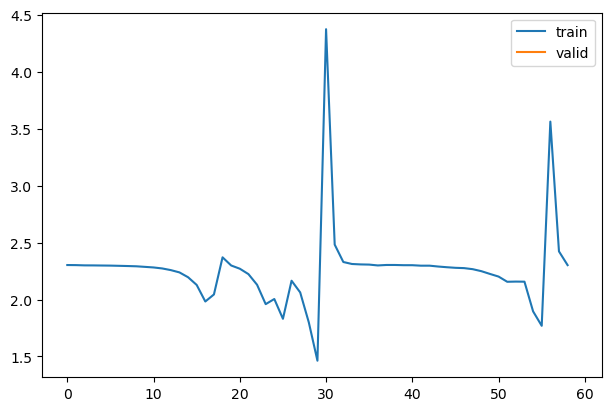

<tinyai.learner.TrainLearner>

In [ ]:
fit(model)

<matplotlib.legend.Legend>

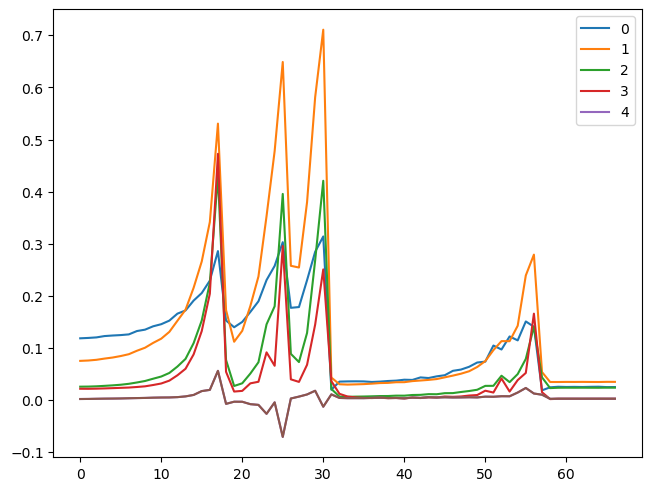

In [ ]:
for l in act_means: plt.plot(l)
plt.legend(range(5))

<matplotlib.legend.Legend>

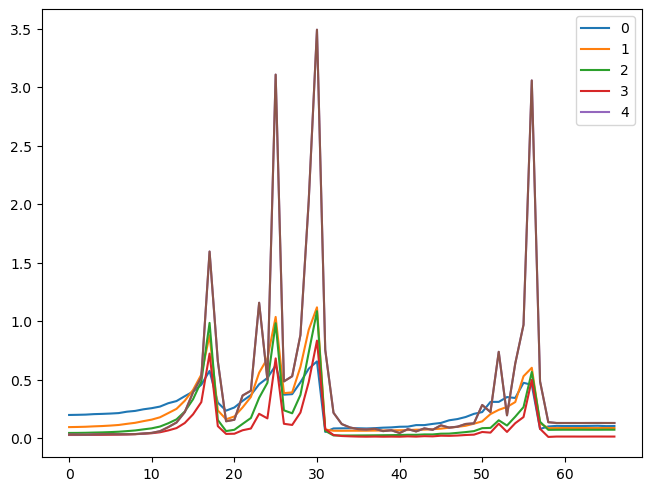

In [ ]:
for l in act_stds: plt.plot(l)
plt.legend(range(5))

## TinyAI Hooks

In [ ]:
class Hook:
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

In [ ]:
set_seed(1)
model = nn.Sequential(*get_model())

In [ ]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

Epoch,Train,Loss,MulticlassAccuracy
0,eval,2.2974,0.0983


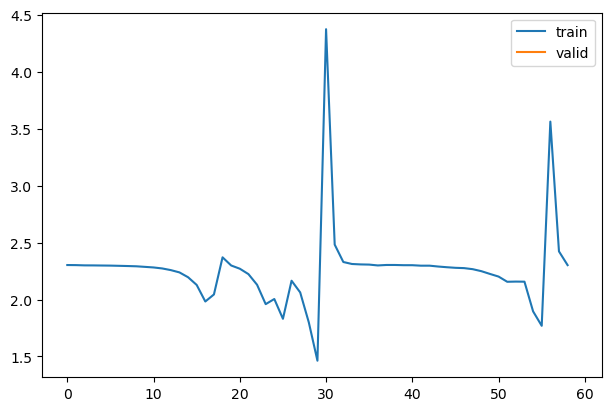

<tinyai.learner.TrainLearner>

In [ ]:
fit(model)

In [ ]:
def get_hist(h): return torch.stack(h.stats[2]).T.float().log1p()

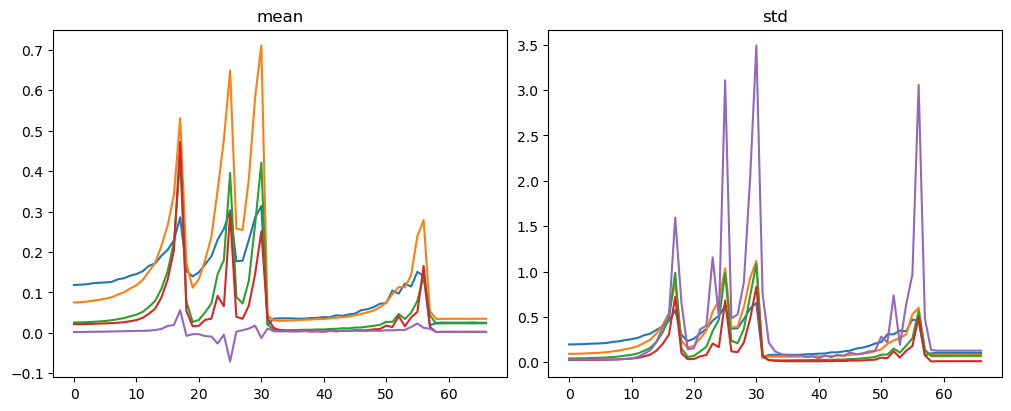

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('mean')
ax2.set_title('std')
for h in hooks:
    ax1.plot(h.stats[0])
    ax2.plot(h.stats[1])

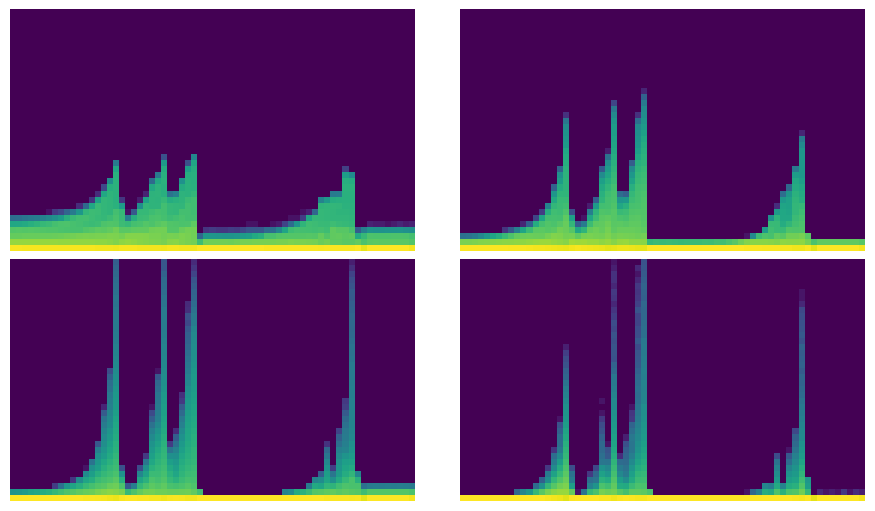

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(9,5))
for ax,h in zip(axes.flatten(), hooks[:4]):
    show_image(get_hist(h), ax, origin='lower')

In [ ]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).T.float()
    return h1[0]/h1.sum(0)

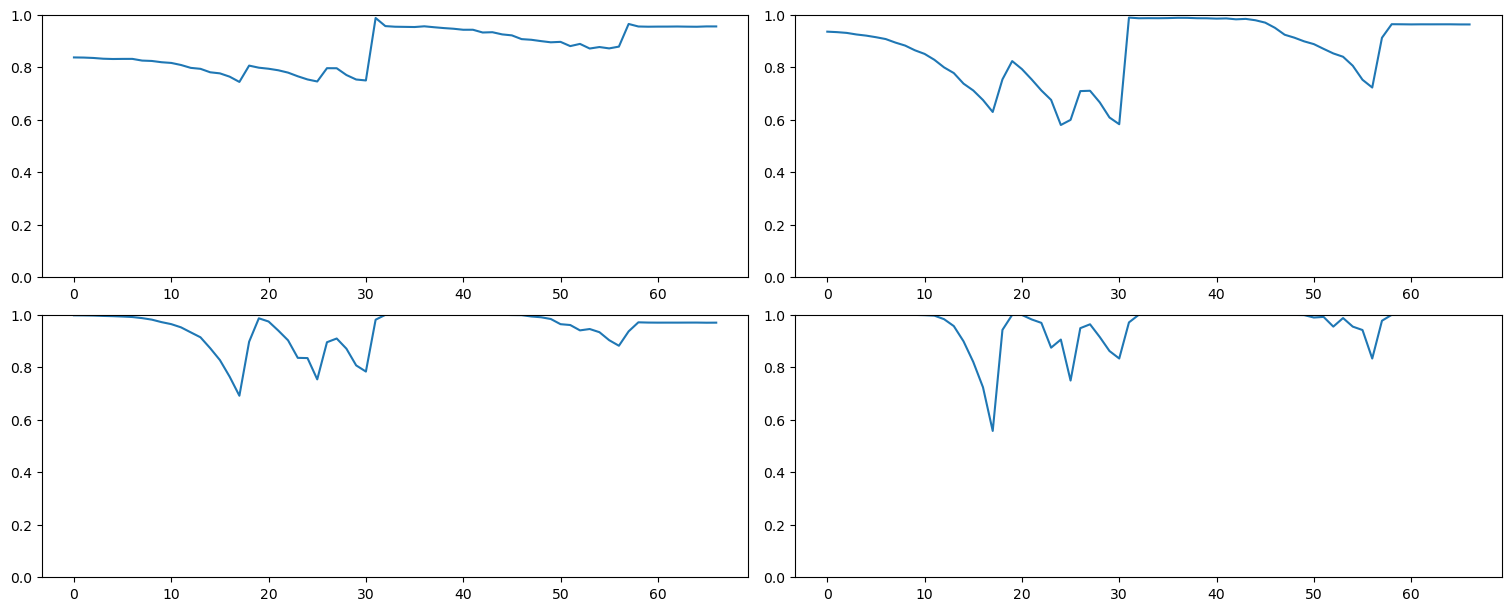

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(15, 6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)


Epoch,Train,Loss,MulticlassAccuracy
0,eval,2.2980,0.1013
1,eval,2.3081,0.0520
2,eval,0.9370,0.6671
3,eval,0.6848,0.7613
4,eval,0.5891,0.7765


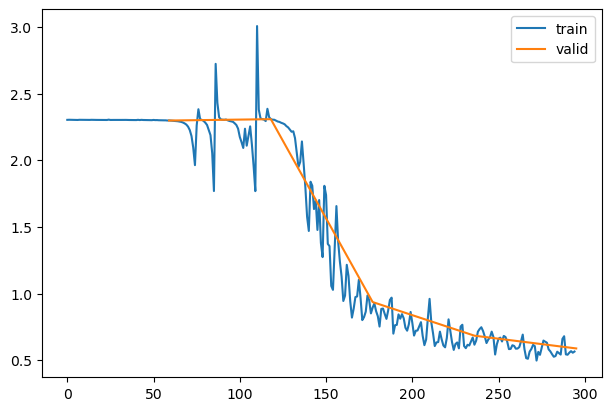

In [ ]:
l = fit(nn.Sequential(*get_model()), 5)

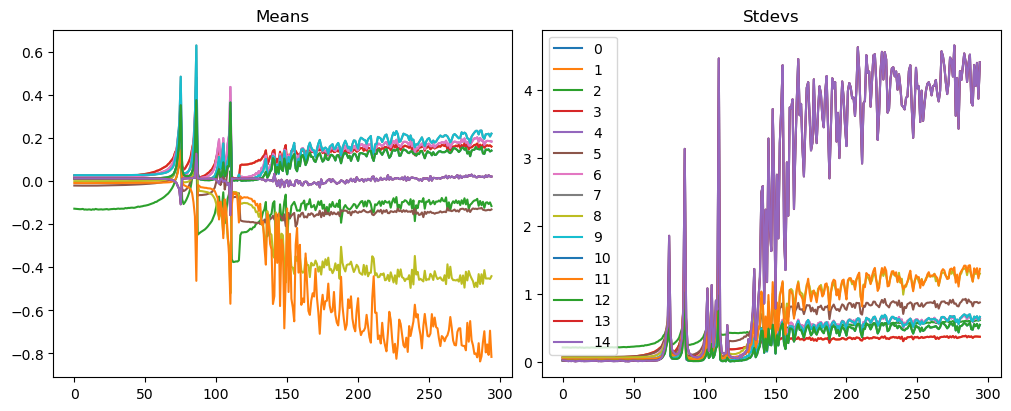

In [ ]:
astats.plot_stats()

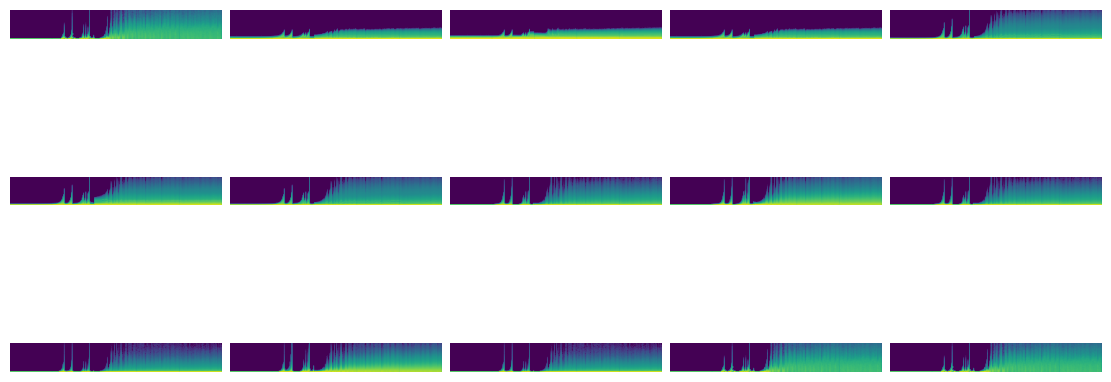

In [ ]:
astats.color_dim()

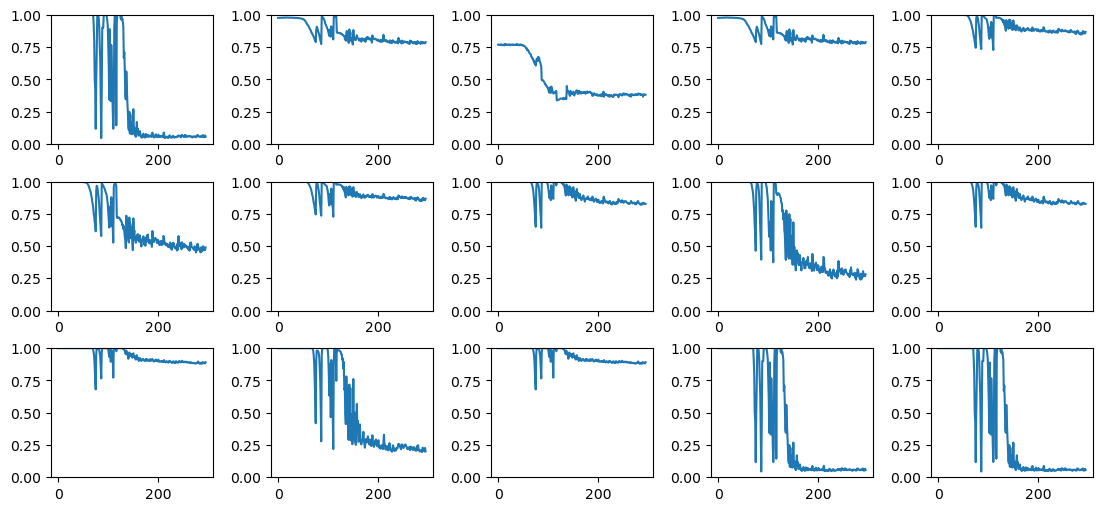

In [ ]:
astats.dead_chart()